## LESSON 1 - Sebastian Héctor Zuzunaga Rosado - 211006957

##  Propósito 

O propósito deste notebook é usar o que foi aprendido na primeira lição de FastAI para tentar diferenciar entre fungos que podem ser comestíveis e venenosos, isto para ajudar as pessoas que se encontrem buscando alimento em florestas.

## Passo 1: Pesquisar imagens de fungos


Primeiro vai ser instalado Duck Duck Go para ser capaz de realizar a busca.


In [9]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

Os recursos necessários serão importadas e a função para procurar e armazenar as imagens será definida.

In [10]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Agora vão ser feitas pesquisas, fotos de cogumelos comestíveis e venenosos, embora não seja necessário um grande número de dados, eu decidi procurar 100 imagens para tentar obter maior variedade.

In [11]:
searches = 'poisonous mushrooms','edible mushrooms'
path = Path('edible_or_poisonous')
from time import sleep
from fastdownload import download_url
from fastai.vision.all import *

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'poisonous mushrooms photo'
Searching for 'edible mushrooms photo'


## Passo 2: Treinar o modelo

Se as imagens não são baixadas corretamente isso pode afetar o modelo então eles vão ser excluídos.

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

Para o treinamento será utilizado um datablock o qual se encarregará de criar os dataset de treinamento e verificação, usados para criar o modelo e para a precisão do mesmo, além disso aqui também se configuram os parâmetros essenciais para seu correto funcionamento.

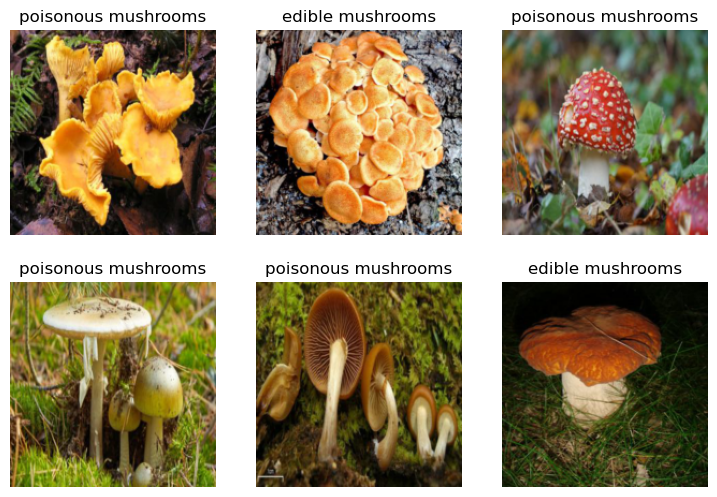

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.992839,0.356357,0.111111,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.420651,0.131298,0.055556,00:52
1,0.280947,0.118311,0.027778,00:53
2,0.197675,0.141744,0.027778,00:52
3,0.151204,0.130649,0.027778,00:52


## Passo 3: Usar o modelo

Agora vamos ver alguns casos de uso para ver se o modelo funciona corretamente.

Vai-se buscar uma imagem de uma espécie de cogumelo chamada Amanita Muscaria, é um cogumelo venenoso com uma aparência muito peculiar pelo qual deveria ser fácil que o modelo o identifique

In [38]:
urls = search_images('red cap mushroom', max_images=1) 
urls[0]

Searching for 'red cap mushroom'


'http://asergeev.com/p/xl-2017-2154-02/saint_petersburg_russia-red_caps_fly_agaric_mushrooms.jpg'

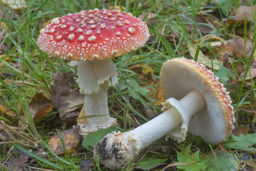

In [39]:
dest = 'amanita.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [40]:
is_edible,_,probs = learn.predict(PILImage.create('amanita.jpg'))
print(f"This is a: {is_edible}.")
print(f"Probability it's poisonous: {1-probs[0]:.4f}")

This is a: poisonous mushrooms.
Probability it's poisonous: 1.0000


Agora se buscará uma espécie de fungo venenoso chamado anjo da morte, o qual é similar em aparência ao cogumelo comum, que é comestível, o modelo deveria ter algo de dificuldade para identificar este fungo.

In [49]:
urls = search_images('destroying angel mushroom', max_images=1)
urls[0]

Searching for 'destroying angel mushroom'


'http://4.bp.blogspot.com/-84cXBcQc6_Q/UETqrx9fRyI/AAAAAAAABRs/i3451Ivx7p4/s1600/Amanita_bisporigera_17932.jpg'

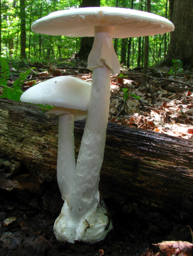

In [50]:
dest = 'angel.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [51]:
is_edible,_,probs = learn.predict(PILImage.create('angel.jpg'))
print(f"This is a: {is_edible}.")
print(f"Probability it's poisonous: {1-probs[0]:.4f}")

This is a: edible mushrooms.
Probability it's poisonous: 0.0233


Finalmente vamos procurar o fungo Morel, uma espécie que é 100% comestível.

In [52]:
urls = search_images('morel mushroom', max_images=1)
urls[0]

Searching for 'morel mushroom'


'http://www.gannett-cdn.com/-mm-/84752a853152af66d44522e8c491426c188f4ea5/c%3D0-245-2848-4042%26r%3D537%26c%3D0-0-534-712/local/-/media/2016/04/08/Louisville/Louisville/635957311375623317-morel.mushroom.jpg'

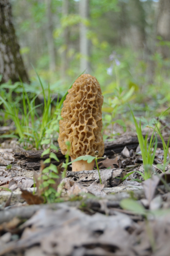

In [53]:
dest = 'morel.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [54]:
is_edible,_,probs = learn.predict(PILImage.create('morel.jpg'))
print(f"This is a: {is_edible}.")
print(f"Probability it's poisonous: {1-probs[0]:.4f}")

This is a: edible mushrooms.
Probability it's poisonous: 0.1147


## Conclusão

Embora o modelo seja suficientemente capaz de distinguir entre fungos venenosos e comestíveis para classificar espécies muito diferentes umas das outras, este possui dificuldades para poder identificar fungos que se parecem entre si, talvez isto seja porque os dados são pesquisados no Duck Duck Go em vez de uma base de dados que apresente informações mais confiáveis.